# Starling Task across subject behavioral data analysis
Let's start the analysis based on Rhiannon's list [here](https://uofutah-my.sharepoint.com/:w:/g/personal/u1363968_umail_utah_edu/ESn4E7plikFIs1ZyLHy5YaUBZfn_td7fv2yCh6I5HsWL2g?e=MxDJfG&CID=0428038a-a81f-6b6f-5c00-c8f4ada097eb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns 
from matplotlib.ticker import MaxNLocator

## functions:

### bar plot function for the blocks

In [2]:
def plot_with_error_bars(data, y_column_mean, x_labels, title, y_label, colors, annotation_offset):
    fig, ax = plt.subplots(dpi=130, figsize=(4, 4))
    
    # Plot the bars
    bars = ax.bar(data['block_type'], data[y_column_mean], color=colors, capsize=5, width=0.5)

    # Add annotations above bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, height, f'{height:.5}', 
            ha='center', va='bottom', fontsize=10, color='black', weight='bold'
        )

    # Remove the top and right spines
    ax.grid(False)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    # Set custom x-tick labels
    ax.set_xticks([bar.get_x() + bar.get_width() / 2 for bar in bars])
    ax.set_xticklabels(x_labels)

    # Set y-axis limits
    max_y = data[y_column_mean].max() 
    ax.set_ylim(0, max_y)
    ax.set_ylabel(y_label)

    # Adjust title position
    plt.xlabel('block')
    plt.title(title, pad=20)  # Increase the pad to bring title higher above the plot

    plt.show()


# ****************************************************************************

## reading the participant data

In [3]:
folder_path = 'single_participant'
dataframes = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        
        # Calculate mean and standard deviation of spaceRT
        # Calculate 3*std for spaceRT and add as a new column we do this for knowing the spaceRT outliers and remove them in
        # calculating spaceRT cause these are rest somehow 
        # the spaceRT_3sd is obviously same in all columns cause it's based on all the spaceRTs. I just wanted to have everything
        # in the dataframe
        mean_spaceRT = df['spaceRT'].mean()
        std_spaceRT = df['spaceRT'].std()
        df['spaceRT_3sd'] = mean_spaceRT + 3 * std_spaceRT
        

        dataframes.append(df)

dataframes[0].head(3)

,arrowRT,distribution,interTrialInterval,outcome,myCard,yourCard,spaceRT,totalReward,trialIndex,trialType,choice,block,timeoutRepeat,spaceRT_3sd
0,1013.0,uniform,906.0,win,4.0,1.0,13679.0,10.5,0.0,response,arrowup,1.0,0.0,4443.13569
1,2090.0,uniform,936.0,win,2.0,9.0,6371.0,11.0,1.0,response,arrowdown,1.0,0.0,4443.13569
2,969.0,uniform,862.0,win,4.0,6.0,2076.0,11.5,2.0,response,arrowdown,1.0,0.0,4443.13569


#  ****************************************************************************

## data preprocessing

1. sometimes block 2 is high and sometimes is low also sometimes block 3 is high and sometimes is low.
So I am adding another column to the dataframes called block_type and it could be: high, low, mix and uniform. 

In [4]:
for df in dataframes:
    df['block_type'] = None

    df.loc[df['block'] == 1, 'block_type'] = 'uniform'     # Block 1 is uni
    df.loc[df['block'] == 4, 'block_type'] = 'mix'     # Block 4 is mix

    # For blocks 2 and 3, set based on distribution
    df.loc[(df['block'] == 2) & (df['distribution'] == 'low'), 'block_type'] = 'low'
    df.loc[(df['block'] == 2) & (df['distribution'] == 'high'), 'block_type'] = 'high'
    df.loc[(df['block'] == 3) & (df['distribution'] == 'low'), 'block_type'] = 'low'
    df.loc[(df['block'] == 3) & (df['distribution'] == 'high'), 'block_type'] = 'high'

## number of participants

In [5]:
n_participant = len(dataframes)
print(f"there are {n_participant} participants.")

there are 1 participants.


### visualization prerequisites:
this order is very important in adding all the analysis block labels!

In [6]:
x_labels = ['uniform','low', 'high', 'mix']
colors = ['#808080',  '#ff7f0e', '#2ca02c', '#8B4513']

# ****************************************************************************

<h2 style="color: red;">(1) Fixed Block: Accuracy.</h2>

### (a) For each block. 

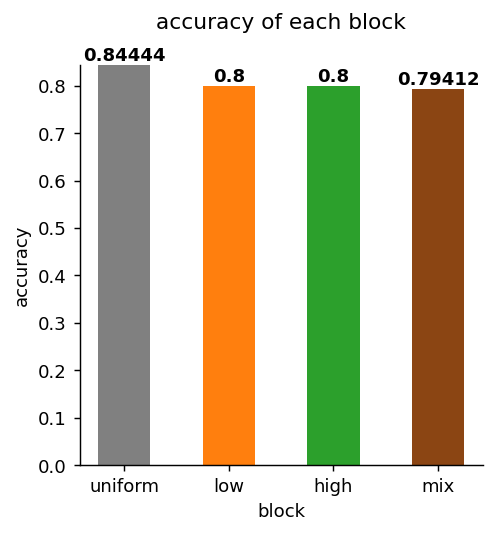

In [7]:
win_rates_all_participants = []

for df in dataframes:
    df['is_win'] = df['outcome'].apply(lambda x: 1 if x == 'win' else 0)
    total_trials = df.groupby('block_type').size().reset_index(name='total_trials')
    wins_per_block_type = df.groupby('block_type')['is_win'].sum().reset_index(name='wins')
    win_rate_df = pd.merge(total_trials, wins_per_block_type, on='block_type')
    win_rate_df['win_rate'] = win_rate_df['wins'] / win_rate_df['total_trials']
    
    win_rates_all_participants.append(win_rate_df[['block_type', 'win_rate']])

combined_win_rates = pd.concat(win_rates_all_participants)
mean_win_rates = combined_win_rates.groupby('block_type')['win_rate'].mean().reset_index()

mean_win_rates['block_type'] = pd.Categorical(
    mean_win_rates['block_type'], 
    categories=x_labels, 
    ordered=True
)

mean_win_rates = mean_win_rates.sort_values(by='block_type').reset_index(drop=True)

plot_with_error_bars(
    data=mean_win_rates,
    y_column_mean='win_rate',
    x_labels=x_labels,           
    title='accuracy of each block',
    y_label='accuracy',
    colors=colors,               
    annotation_offset=0.05
)


# ****************************************************************************

<h2 style="color: red;">(2) Fixed Block: Response Time.</h2>

### (a) Average for each block for card reveal 

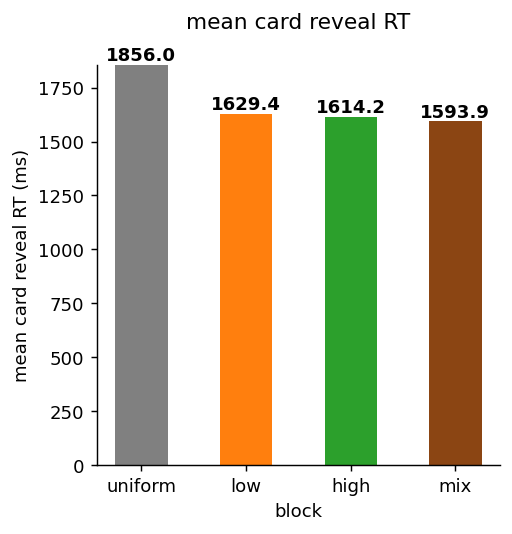

In [8]:
spaceRT_all_participants = []

for df in dataframes:

        # Get the spaceRT_3sd threshold (same value across all rows in each DataFrame)
    spaceRT_3sd_threshold = df['spaceRT_3sd'].iloc[0]
    
    # Filter out rows where spaceRT is greater than spaceRT_3sd threshold
    df_filtered = df[df['spaceRT'] <= spaceRT_3sd_threshold]

    # Calculate mean spaceRT per block_type for the current participant
    mean_spaceRT_df = df.groupby('block_type')['spaceRT'].mean().reset_index()
    mean_spaceRT_df.rename(columns={'spaceRT': 'mean_spaceRT'}, inplace=True)
    
    # Append the mean spaceRT values to the list
    spaceRT_all_participants.append(mean_spaceRT_df[['block_type', 'mean_spaceRT']])

# Concatenate all mean spaceRT dataframes and calculate the mean
combined_spaceRT = pd.concat(spaceRT_all_participants)
mean_spaceRT = combined_spaceRT.groupby('block_type')['mean_spaceRT'].mean().reset_index()

# Ensure the order of block_type in mean_spaceRT matches x_labels
mean_spaceRT['block_type'] = pd.Categorical(
    mean_spaceRT['block_type'], 
    categories=x_labels, 
    ordered=True
)

# Sort mean_spaceRT by the specified block_type order
mean_spaceRT = mean_spaceRT.sort_values(by='block_type').reset_index(drop=True)

# Plotting function without standard deviation
plot_with_error_bars(
    data=mean_spaceRT,
    y_column_mean='mean_spaceRT',
    x_labels=x_labels,            # Use x_labels in the specified order
    title='mean card reveal RT',
    y_label='mean card reveal RT (ms)',
    colors=colors,                # Use colors in the specified order
    annotation_offset=100
)


### (b) Average for each block for card response 

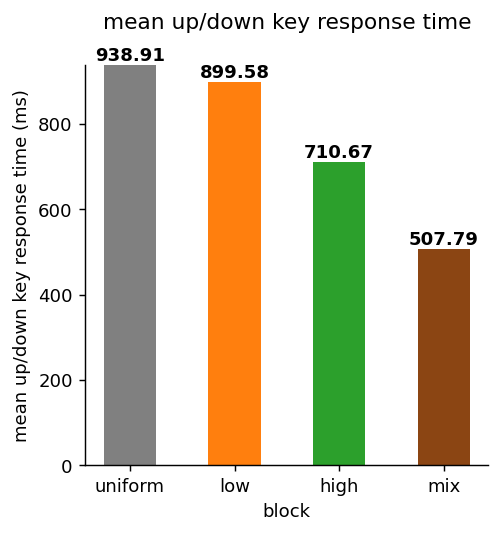

In [9]:
arrowRT_all_participants = []

for df in dataframes:
    # Filter out rows where arrowRT is 'na' (string), then convert arrowRT to numeric
    df_filtered = df[df['arrowRT'] != 'na'].copy()
    df_filtered['arrowRT'] = pd.to_numeric(df_filtered['arrowRT'], errors='coerce')  # Ensure numeric conversion

    # Calculate mean arrowRT per block_type for the current participant
    mean_arrowRT_df = df_filtered.groupby('block_type')['arrowRT'].mean().reset_index()
    mean_arrowRT_df.rename(columns={'arrowRT': 'mean_arrowRT'}, inplace=True)
    
    # Append the mean arrowRT values to the list
    arrowRT_all_participants.append(mean_arrowRT_df[['block_type', 'mean_arrowRT']])

# Concatenate all mean arrowRT dataframes and calculate the mean and standard deviation
combined_arrowRT = pd.concat(arrowRT_all_participants)
mean_arrowRT = combined_arrowRT.groupby('block_type')['mean_arrowRT'].mean().reset_index()
std_arrowRT = combined_arrowRT.groupby('block_type')['mean_arrowRT'].std().reset_index()

# Merge mean and standard deviation dataframes
mean_arrowRT = mean_arrowRT.merge(std_arrowRT, on='block_type', suffixes=('_mean', '_std'))

# Ensure the order of block_type in mean_arrowRT matches x_labels
mean_arrowRT['block_type'] = pd.Categorical(
    mean_arrowRT['block_type'], 
    categories=x_labels, 
    ordered=True
)

# Sort mean_arrowRT by the specified block_type order
mean_arrowRT = mean_arrowRT.sort_values(by='block_type').reset_index(drop=True)

# Plotting function
plot_with_error_bars(
    data=mean_arrowRT,
    y_column_mean='mean_arrowRT_mean',
    x_labels=x_labels,                # Use x_labels in the specified order
    title='mean up/down key response time',  # lowercase title
    y_label='mean up/down key response time (ms)',               # lowercase y-axis label
    colors=colors,                     # Use colors in the specified order
    annotation_offset=100
)


### (c) Average difference between blocks 

In [10]:
# ToDo: not sure what this is; ask Rhia

# ****************************************************************************

<h2 style="color: red;">(2_1) Other interesting analysis on arrowRT </h2>

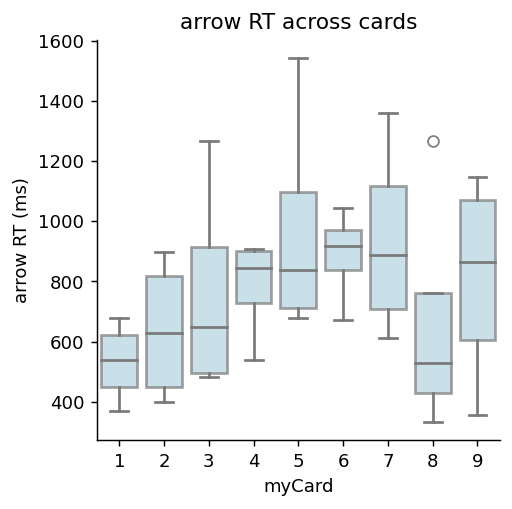

In [11]:
arrowRT_by_card_block_all_participants = []

for df in dataframes:
    # Convert 'arrowRT' to numeric, with errors set to NaN for non-numeric values
    df['arrowRT'] = pd.to_numeric(df['arrowRT'], errors='coerce')
    
    # Group by 'myCard' and 'block_type' and calculate the mean arrowRT
    arrow_rt_means = df.groupby(['myCard', 'block_type'])['arrowRT'].mean().reset_index()
    
    # Append the results to the list
    arrowRT_by_card_block_all_participants.append(arrow_rt_means)

# Concatenate all dataframes
combined_arrowRT = pd.concat(arrowRT_by_card_block_all_participants)

# Convert 'myCard' to integer to ensure x-axis labels are integers
combined_arrowRT['myCard'] = combined_arrowRT['myCard'].astype(int)

# Now group by 'myCard' to get the mean and standard deviation of arrowRT across all participants
mean_std_arrowRT_across_participants = combined_arrowRT.groupby('myCard')['arrowRT'].agg(['mean', 'std']).reset_index()

plt.figure(dpi=130, figsize=(4, 4))

# Create the boxplot with customized outliers
sns.boxplot(
    data=combined_arrowRT,
    x='myCard',
    y='arrowRT',
    color='lightblue',
    boxprops=dict(alpha=0.7),
    flierprops=dict(marker='o', markerfacecolor='none', markeredgecolor='gray', markersize=6)  # Custom outliers
)

# Add labels and title
plt.xlabel('myCard')
plt.ylabel('arrow RT (ms)')
plt.title('arrow RT across cards')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()